# preprocess the linespline data
## 1. clean linsplan file, get out the info and store all the data in dataframe

In [15]:
## import support libraries
import pandas as pd
from pandas import DataFrame 
import re
import os
import unittest

In [34]:
## get the original dimensions of the vessel

file_path = r'C:\Users\907932\Desktop\Software\Diffrac_related\Diffrac database\001_linesplan database\Original linesplan database Journee Versluis\Versluis.001'
with open(file_path) as linesplan_info:
            raw_info = linesplan_info.read().split('\n')
            info = raw_info[1]
            info_crossection = raw_info[3]
            info_pro = info.split(' ')
            vessel_name = info_pro[0][:-1]
            
            try:
                float(info_pro[2])
                vessel_type = info_pro[1]
                vesselLoA = float(info_pro[2])
                vesselBeam = float(info_pro[4])
                vesselDraft = float(info_pro[6])
                vesselDepth = float(info_pro[7][1:-1])
            except:
                vessel_type = info_pro[1] + info_pro[2]
                vesselLoA = float(info_pro[3])
                vesselBeam = float(info_pro[5])
                vesselDraft = float(info_pro[7])
                vesselDepth = float(info_pro[8][1:-1])
            num_cross_sections_pattern = re.compile(r'\d+')
            num_cross_sections_int = int(num_cross_sections_pattern.search(info_crossection).group(0))

            linesplan_info.close()



In [35]:
## get the coordinates of the scatters 
import numpy as np
import tkinter as tk
import linecache
import math
import re

'''
Hanwei Wangd RHDHV 7_2_2019
'''

class linesplan():
    def __init__(self, linsplan_path):
        self.L = None
        self.B = None
        self.T = None  # draft of the ship
        self.D = None  # depth of the ship
        self.name = None
        self.type = None
        self.coordinate = None
        self.num_cross_section = None
        self.fractions = None
        self.scaling_flag = None
        self.kxx = None
        self.kyy = None
        self.KG = None
        self.displacement = None
        self.file_path = linsplan_path

    def get_info(self):
        # get the originald ship dimensions(L, B, T, D)
        with open(self.file_path) as linesplan_info:
            raw_info = linesplan_info.read().split('\n')
            info = raw_info[1]
            info_crossection = raw_info[3]
            info_pro = info.split(' ')
            vessel_name = info_pro[0][:-1]
            
            try:
                float(info_pro[2])
                vessel_type = info_pro[1]
                vesselLoA = float(info_pro[2])
                vesselBeam = float(info_pro[4])
                vesselDraft = float(info_pro[6])
                vesselDepth = float(info_pro[7][1:-1])
            except:
                vessel_type = info_pro[1] + info_pro[2]
                vesselLoA = float(info_pro[3])
                vesselBeam = float(info_pro[5])
                vesselDraft = float(info_pro[7])
                vesselDepth = float(info_pro[8][1:-1])
            num_cross_sections_pattern = re.compile(r'\d+')
            num_cross_sections_int = int(num_cross_sections_pattern.search(info_crossection).group(0))

            linesplan_info.close()
            
            self.L = vesselLoA
            self.B = vesselBeam
            self.T = vesselDraft
            self.D = vesselDepth
            self.name = vessel_name
            self.type = vessel_type
            self.num_cross_section = num_cross_sections_int
        linesplan_info.close()

    def get_fraction(self):

        fractions = []
        fraction_start = 4
        fraction_end = 4 + 1 + math.ceil((self.num_cross_section + 1)/6)
        for i in np.arange(fraction_start+1,fraction_end):
            line = linecache.getline(self.file_path, i)
            for fraction in line.strip('\n').split(' '):
                # print(fraction)
                if fraction != '':
                    fractions.append(float(fraction))
        self.fractions = fractions

    def get_coordinate(self):
        # First find the origin of the ship
        # X_0 is the stern of ship, y_0 is central line, z_0 is keel
        fraction_sum = [0]
        for i in range(1, len(self.fractions)+1):   # 千万注意啊
            fraction_sum.append(sum(self.fractions[0: i]))

        # print(' fraction: {}'.format(fraction_sum))
        x_cors = np.array(fraction_sum) * self.L
        
#         self.coordinate_df = DataFrame({'Crossection':[] , 'x': [], 'y':[], 'z':[]})
        self.crossection_list = []
        self.x_list = []
        self.y_list = []
        self.z_list = []
        
        with open(self.file_path, 'r') as linesplan:
             content = linesplan.read().split('\n')
             Content = []
             effective_content = content[4 + math.ceil((self.num_cross_section)/6) + 1: -3]
             for items in effective_content:
                 for item in items.split(' '):
                     if item != '':
                        Content.append(float(item))
             count = 0
             Coordinates = []

             while Content:
                 index = 1
                 num_points_per_section = int(Content[index]) + 1
                 z_cor = np.array(Content[index + 3: index + num_points_per_section*2 + 3 : 2]) * self.T
                 z_cor = np.sort(z_cor)
                 y_cor = np.array(Content[index + 2: index + num_points_per_section*2 + 2 : 2]) * self.B # !!!!!!!
                 y_cor = np.sort(y_cor)
                 # if count == 0:
                 #     y_cor = np.insert( y_cor, 0, self.T)
                 #     z_cor = np.insert(z_cor,0, 0)
                 Content = Content[index + num_points_per_section*2 + 2: ] # 不是-1, 因为列表不会包含最后一个值
                 # organize coordinate per section
                    
                 try:
                     x_cor = np.ones(len(y_cor)) * x_cors[count]
                     crossection = ['Crossection' + str(count).zfill(2)] * len(y_cor) # obj.zfill(2) 补零至两位
                     self.x_list += x_cor.tolist()
                     self.y_list += y_cor.tolist()
                     self.z_list += z_cor.tolist()
                     self.crossection_list += crossection
                     count += 1
                 except:
                     print('The ship model is wrong, you may lose the last cross-section!')

             linesplan.close()
             # Coordinates[0] = np.insert(Coordinates[0], 0, (0 , 0, self.T))
             # Coordinates[-1] = np.append(Coordinates[-1], (self.L, 0, self.T))
             # self.num_cross_section = self.num_cross_section
             DF_feed = {'Crossection': self.crossection_list,
                        'X': self.x_list,
                        'Y': self.y_list,
                        'Z': self.z_list}
        self.coordinate_df = DataFrame(DF_feed)

In [36]:
linesplan_processor = linesplan(linsplan_path= file_path)
linesplan_processor.get_info()
linesplan_processor.get_fraction()
linesplan_processor.get_coordinate()

In [37]:
len(linesplan_processor.fractions)

20

In [38]:
linesplan_processor.coordinate_df

,Crossection,X,Y,Z
0,Crossection00,0.000000,0.000000,8.446274
1,Crossection00,0.000000,0.625040,8.938006
2,Crossection00,0.000000,1.499046,9.624420
3,Crossection00,0.000000,2.302538,10.309920
4,Crossection00,0.000000,3.005394,11.004560
5,Crossection01,7.608225,0.000000,2.998834
6,Crossection01,7.608225,0.049999,2.998834
7,Crossection01,7.608225,0.099997,2.998834
8,Crossection01,7.608225,0.125008,3.997836
9,Crossection01,7.608225,0.149996,4.997752


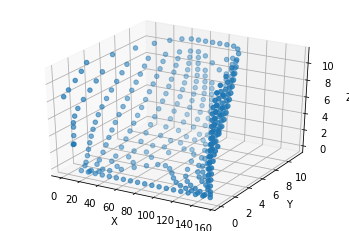

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(linesplan_processor.coordinate_df['X'], linesplan_processor.coordinate_df['Y'], linesplan_processor.coordinate_df['Z'])
threedee.set_xlabel('X')
threedee.set_ylabel('Y')
threedee.set_zlabel('Z')
plt.show()

## mirror the ship and remove the duplicates points 

In [40]:
another_half_df = linesplan_processor.coordinate_df.copy()
another_half_df['Y'] = another_half_df['Y'] * (-1) 
linesplan_processor.coordinate_df_full = linesplan_processor.coordinate_df.append(another_half_df).drop_duplicates()

## sort the data frame squentially
linesplan_processor.coordinate_df.sort_values(by = ['Crossection', 'X', 'Y'])


,Crossection,X,Y,Z
0,Crossection00,0.000000,0.000000,8.446274
1,Crossection00,0.000000,0.625040,8.938006
2,Crossection00,0.000000,1.499046,9.624420
3,Crossection00,0.000000,2.302538,10.309920
4,Crossection00,0.000000,3.005394,11.004560
5,Crossection01,7.608225,0.000000,2.998834
6,Crossection01,7.608225,0.049999,2.998834
7,Crossection01,7.608225,0.099997,2.998834
8,Crossection01,7.608225,0.125008,3.997836
9,Crossection01,7.608225,0.149996,4.997752


## 2. scale and cut the ship

LOA: 152.5m
Beam: 22.82m
Depth 11.0m
Draft: 9.14m



c:\users\907932\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\907932\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


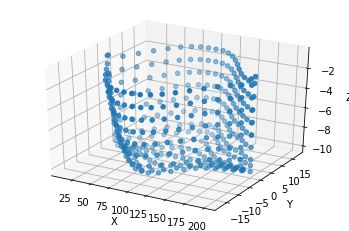

In [41]:
print(('LOA: {}m\n'\
      'Beam: {}m\n'\
       'Depth {}m\n'\
      'Draft: {}m\n').format(linesplan_processor.L, linesplan_processor.B, linesplan_processor.D,linesplan_processor.T))


Ori_dim_LBDT_list = [linesplan_processor.L, 
                     linesplan_processor.B,
                     linesplan_processor.D,
                     linesplan_processor.T]

New_dim_LBDT_list = [200, 35, 20,10]
ratio_list = [New_dim_LBDT_list[0]/linesplan_processor.L,
              New_dim_LBDT_list[1]/linesplan_processor.B,
              New_dim_LBDT_list[2]/linesplan_processor.D]

New_ship_df_half = linesplan_processor.coordinate_df.copy()
New_ship_df_half['X'] = New_ship_df_half['X'] * ratio_list[0]
New_ship_df_half['Y'] = New_ship_df_half['Y'] * ratio_list[1]
New_ship_df_half['Z'] = New_ship_df_half['Z'] * ratio_list[2]

New_ship_df_anohalf = New_ship_df_half.copy()
New_ship_df_anohalf['Y'] = New_ship_df_anohalf['Y'] * (-1) 
New_ship_df_full = New_ship_df_half.append(New_ship_df_anohalf).drop_duplicates()

## sort the data frame squentially
New_ship_df_full.sort_values(by = ['Crossection', 'X', 'Y'])


## cut the ship
New_ship_cut_df_half = New_ship_df_half[New_ship_df_half['Z'] <= New_dim_LBDT_list[3]]
New_ship_cut_df_full = New_ship_df_full[New_ship_df_full['Z'] <= New_dim_LBDT_list[3]]
New_ship_cut_df_half['Z'] = New_ship_cut_df_half['Z'] - New_dim_LBDT_list[3]
New_ship_cut_df_full['Z'] = New_ship_cut_df_full['Z'] - New_dim_LBDT_list[3]

## visual 
threedee = plt.figure().gca(projection='3d')
threedee.scatter(New_ship_cut_df_full['X'], New_ship_cut_df_full['Y'], New_ship_cut_df_full['Z'])
threedee.set_xlabel('X')
threedee.set_ylabel('Y')
threedee.set_zlabel('Z')
plt.show()


## 3. calculate the main particulars of the vessel

In [79]:
class proship():
    def __init__(self):
        pass
    
    def simpsons(self, arguements, values):
        ''''
        Use simpsons iteration to calculate the area and volume
        '''
        s1 = 0
        s2 = 0
        h = (arguements[-1] - arguements[0]) / (2 * len(arguements))
        index_1 = np.arange(0, len(arguements)-1)
        index_2 = np.arange(1, len(arguements))
        for index in index_1:
            s1 += values[index]
        for index in index_2:
            s2 = s2 + values[index]
        s = h * (values[0] + values[-1] + 4 * s1 + 2 * s2) / 3
        return s
    
    def main_particulars(self, New_dim_LBDT_list, new_vessel_coordinates_df, new_vessel_coordinates_half_df):
        x = []
        y = []
        z = []
        self. num_crossection = list(set(new_vessel_coordinates_df['Crossection']))
#         j = 0
#         # k = 0
#         for cross_section in data:
#             self.num_crossection += 1
#             for point in list(cross_section):
#                 self.x.append(point[0])
#                 if point[2] in y:
#                     j += 1
#                     self.y.append(point[2]+ 0.1*j)
#                     y.append(point[2]+ 0.1*j)
#                 else:
#                     self.y.append(point[2])
#                     y.append(point[2])
#                 self.z.append(point[1])
#                 x.append(point[0])
#                 z.append(point[1])
#             j = 0
#             Crossection = np.vstack((x, y, z))
#             Crossection = Crossection[:, Crossection[1, :].argsort()]  # Crossection is the half ship body
#             ##############
#             Crossection_next  = np.vstack((Crossection[0,1:], -Crossection[1,1:], Crossection[2,1:]))
#             Crossection_next  = Crossection_next[:, Crossection_next[1,:].argsort()]
#             Crossection_whole = np.hstack((Crossection_next[:, :], Crossection))

#             # for point in list(cross_section):
#             #     # print(point)
#             #     if point[2] != 0:
#             #         self.x.append(point[0])
#             #         if -point[2] in self.y:
#             #             k += 1
#             #             self.y.append(-point[2])
#             #             y.append(-point[2]-0.01*k)
#             #         else:
#             #             self.y.append(-point[2])
#             #             y.append(-point[2])
#             #         self.z.append(point[1])
#             #         x.append(point[0])
#             #         z.append(point[1])
#             #
#             # crossection = np.vstack((x, y, z)) # crossection is the whole body, but only for visualization
#             # crossection = crossection[:, crossection[1, :].argsort()]  # 按照数组的一个维度排序
#             # print('j = {}'.format(j))
#             # print('k = {}'.format(k))
#             x = []
#             y = []
#             z = []

#             # plot the crossections
#             # ax.plot(Crossection_whole[0, :], Crossection_whole[1, :], Crossection_whole[2, :], c='r')

#             # plot the water lid
#             # ax.plot([Crossection_whole[0, 0], Crossection_whole[0, -1]], [Crossection_whole[1, 0], Crossection_whole[1, -1]],
#             #         [Crossection_whole[2, 0], Crossection_whole[2, -1]], c='g')
#             half_crossection.extend(Crossection)
#             crossections.extend(Crossection_whole)

#             # plot the vertical water plane

#             ax.scatter(self.x[0: :2], self.y[0: :2], self.z[0: :2], c='b', marker="o", alpha=0.5)
#             # ax.plot(self.x[0::2], self.y[0::2], self.z[0::2], c='b', alpha=0.5)
#             # ax.plot(  )
#         self.half_crossection = half_crossection
#         self.crossections = crossections

        '''
        Data collecting ends here
        Start data Processing 
        '''
        '''
        # 1, calculate the water plane area
        '''
        # First create a nutural line at surface
        crossection = list(set(new_vessel_coordinates_df['Crossection']))
        crossection.sort()
        x = list(set(new_vessel_coordinates_df['X']))
        x.sort()
        nutural_line_1_x = x
        nutural_line_1_y = list(np.array(nutural_line_1_x) * 0)
        nutural_line_1_z = list(np.ones(len(nutural_line_1_x)) * New_dim_LBDT_list[3])
        nutural_line_1_crossection = crossection
        nutural_line_1_feed = {'Crossection': nutural_line_1_crossection,
                                         'X': nutural_line_1_x,
                                         'Y': nutural_line_1_y,
                                         'Z': nutural_line_1_z} 
        nutural_line_1_df = DataFrame(nutural_line_1_feed)
#         nutural_line_1[:,2] = 
#         x_slices = self.crossections[0:-2:3]
#         for i in range(self.num_crossection):
#             nutural_line_1[i,0] = x_slices[i][0]
#         nutural_line_1[:,1] = 0

        # Then create nutural line at keel
        nutural_line_2_crossection = crossection
        nutural_line_2_x = x
        nutural_line_2_y = list(np.array(nutural_line_1_x) * 0)
        nutural_line_2_z = []
        for cros in crossection:
            nutural_line_2_z.append(max(new_vessel_coordinates_df[new_vessel_coordinates_df['Crossection'] == cros]['Z']))
        nutural_line_2_feed = {'Crossection': nutural_line_2_crossection,
                                      'X': nutural_line_2_x,
                                      'Y': nutural_line_2_y,
                                      'Z': nutural_line_2_z}
        nutural_line_2_df = DataFrame(nutural_line_2_feed)
            
#         nutural_line_2[:, 0] = nutural_line_1[:,0]
#         z_slices = self.crossections[2: :3]
#         for i in range(self.num_crossection):
#             nutural_line_2[i, 2] = min(z_slices[i])
#         nutural_line_2[:, 1] = 0

        # Then create contour line
        contour_line_1_crossection = crossection
        contour_line_1_x = x
        contour_line_1_y = []
        for cros in crossection:
            contour_line_1_y.append(max(new_vessel_coordinates_df[new_vessel_coordinates_df['Crossection'] == cros]['Y']))
        contour_line_1_z =  list(np.ones(len(contour_line_1_x)) * New_dim_LBDT_list[3])
        contour_line_1_feed = {'Crossection': contour_line_1_crossection,
                                      'X': contour_line_1_x,
                                      'Y': contour_line_1_y,
                                      'Z': contour_line_1_z}
        contour_line_1_df = DataFrame(contour_line_1_feed)
        print(contour_line_1_feed)
#         contour_line_1 = np.ones([self.num_crossection, 3])
#         contour_line_1[:,2] = self.crossections[2][-1]
#         contour_line_1[:,0] = nutural_line_1[:,0]
#         y_slices = self.crossections[1:-1:3]
#         for i in range(self.num_crossection):
#             contour_line_1[i,1] = max(y_slices[i])

#         # Next half of the contour line
#         contour_line_2 = np.ones([self.num_crossection, 3])
#         contour_line_2[:,2] = self.crossections[2][-1]
#         contour_line_2[:,0] = nutural_line_1[:,0]
#         y_slices = self.crossections[1:-1:3]
#         for i in range(self.num_crossection):
#             contour_line_2[i,1] = -max(y_slices[i])

        # plot
        # plt.plot(nutural_line_1[:, 0], nutural_line_1[:, 1], nutural_line_1[:, 2], c='g', linewidth='1')
        # plt.plot(nutural_line_2[:, 0], nutural_line_2[:, 1], nutural_line_2[:, 2], c='red')
        # plt.plot(contour_line_1[:, 0], contour_line_1[:, 1], contour_line_1[:, 2], c='g', linewidth='1')
        # plt.plot(contour_line_2[:, 0], contour_line_2[:, 1], contour_line_2[:, 2], c='g', linewidth='1')
#         self.out_line = np.hstack((nutural_line_1, nutural_line_2, contour_line_1, contour_line_2))

        # calculate the water plane area by simpson iteration
        self.water_plane = self.simpsons(contour_line_1_df['X'].values, contour_line_1_df['Y'].values) * 2

        print('Water plane area is {} m^2'.format(int(self.water_plane)))

        '''
        #2, calculate the areas of all the cross-sections and then the displacement of the ship
        '''
        area_cross_sections = []
        for index, cros in enumerate(crossection):
            box_area = nutural_line_1_df['Z'].values[index] * contour_line_1_df['Y'].values[index]
            itergration =  self.simpsons(New_ship_cut_df_half[New_ship_cut_df_half['Crossection'] == cros]['Y'].values,
                                         New_ship_cut_df_half[New_ship_cut_df_half['Crossection'] == cros]['Z'].values)
            area_cross_sections.append(box_area - itergration)
                                       
                                 
        self.displacement = abs(self.simpsons(nutural_line_1_df['X'].values, area_cross_sections)*2)
        print('Displacement is {} m^3'.format(self.displacement))

        # calculate the LCF
        # 垂向计算法， 先计算各个水线面面积， 然后将水线面面积按照吃水方向进行积分拉计算浮心位置
        # Yf = 0, Xf
        cross_xy = contour_line_1_df['X'].values * contour_line_1_df['Y'].values
        self.LCF = 2 * self.simpsons(nutural_line_1_df['X'].values, cross_xy)/self.water_plane
    
        '''
        #3 calculate the ship main particulars
        '''
        # Inertia for all the crossections
        self.I = 2/3 * self.simpsons(nutural_line_1[:,0], contour_line_1[:,1]*contour_line_1[:,1]*contour_line_1[:,1])
        # CB
        self.CB = self.displacement/(Lpp*Breadth*Draft)
        # BM
        self.BM = self.I/ self.displacement
        # KB
        '''
        some doubts
        '''
        self.KB = abs(self.simpsons(contour_line_1[:,1], self.water_plane * contour_line_1[:,1])/self.displacement)
        # LCB
        # self.LCB = self.simpsons(contour_line_1[:,1], self.water_plane * (Xf - Lpp/2))/self.displacement
        ''' May not necessary, change it later. '''
        self.LCB = 0.2
        # GM
        ''' KG is user input, here assume is half of depth'''
        self.GM = self.KB + self.BM - Depth/2
        # k_xx, k_yy
        self.k_yy = 0.3 * Lpp
        self.k_xx = 0.25 * Breadth

        '''
        #4 calculate the natural frequencies of ship motions 
        '''
        self.omega_heave = math.sqrt(self.water_plane * 9.81 / self.displacement)  # pay attention for the unit
        self.omega_roll = math.sqrt(self.GM * 9.81/ self.k_xx ** 2)
        self.I_l = 2*self.simpsons(nutural_line_1[:,0], contour_line_1[:,1] * nutural_line_1[:,0] ** 2) - self.LCF ** 2 * self.water_plane
        self.BM_l = self.I_l/self.displacement
        self.GM_l = self.KB + self.BM_l - Depth/2
        self.omega_pitch = math.sqrt(self.GM_l * 9.81/(self.k_yy ** 2))

        print('Heave $\omega$ = {} rad/s\nRoll $\omega$ = {} rad/s\nPitch $\omega$ = {} rad/s'.format(self.omega_heave, self.omega_roll, self.omega_pitch))

        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 1.5 * ratio_y_x, 1.5 * ratio_z_x, 1]))
        ax.set_xlabel('Length [m]')
        ax.set_ylabel('Breadth [m]')
        ax.set_zlabel('Draft [m]')
        ax.set_title(name)
        plt.show()

    
    
        

In [80]:
Ship_pro = proship()
Ship_pro.main_particulars(New_dim_LBDT_list = New_dim_LBDT_list,
                          new_vessel_coordinates_df = New_ship_cut_df_full, 
                          new_vessel_coordinates_half_df = New_ship_cut_df_half)

{'Crossection': ['Crossection01', 'Crossection02', 'Crossection03', 'Crossection04', 'Crossection05', 'Crossection06', 'Crossection07', 'Crossection08', 'Crossection09', 'Crossection10', 'Crossection11', 'Crossection12', 'Crossection13', 'Crossection14', 'Crossection15', 'Crossection16', 'Crossection17', 'Crossection18', 'Crossection19', 'Crossection20'], 'X': [9.977999999999998, 19.97, 29.971999999999994, 39.98199999999999, 49.999999999999986, 60.01999999999999, 70.03999999999999, 80.05599999999998, 90.06599999999997, 100.06999999999998, 110.07199999999997, 120.07599999999998, 130.082, 140.088, 150.08999999999997, 160.08799999999997, 170.07799999999997, 180.05999999999997, 190.036, 200.00599999999997], 'Y': [0.230055, 3.11185, 6.4784999999999995, 9.737, 12.733, 15.029000000000002, 16.5515, 17.325, 17.5, 17.5, 17.296999999999997, 16.3555, 14.825999999999999, 12.698000000000002, 10.1675, 7.525, 5.047, 3.06285, 1.5522500000000001, 0.9233000000000001], 'Z': [10.0, 10.0, 10.0, 10.0, 10.0, 

## 3. calculate the panel size

In [60]:
New_ship_cut_df_full['X'].values[0]

9.977999999999998

3344